# DS Workshop 2 - 15th November 2024
## Team: Rachel Bourke, Emma Cosgrave, Josh Smith, Conor Kennedy

This notebook contains our approach to our first pass of cleaning the dataset (and noting peculiarities for future reference, as they arise), initial feature engineering, and the trainig & evaluation of an XGBoost model.
On our first attempt we achieved an accuracy of 96%.

To improve our model, we plan to:
* Further clean our dataset with added nuance where possible, given our knowledge of the banking domain.
* Use ANOVA and hypothesis testing to analyse the impact of our features on our target variable and help us with further feature engineering.
* Ensure our future training and test sets are statistically similar (apply over/under sampling).

Note: This notebook was written in Kaggle, so the first few cells may have to be edited accordingly in order to import the dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv') #You will have to edit this if not running the notebook in Kaggle

# Raw Data Exploration

In [4]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df.info()

# Dataset information:

# Length: 32581
# Data Types:
    # Continuous: 9
    # Categorical: 4

# Null values found in: 
    # person_emp_length (895)
    # loan_int_rate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [7]:
# Number of entries with approved loans (22% of dataset)
df[df['loan_status'] == 1].shape[0]

7108

# Data Cleaning

## Step 1: Address missing data

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

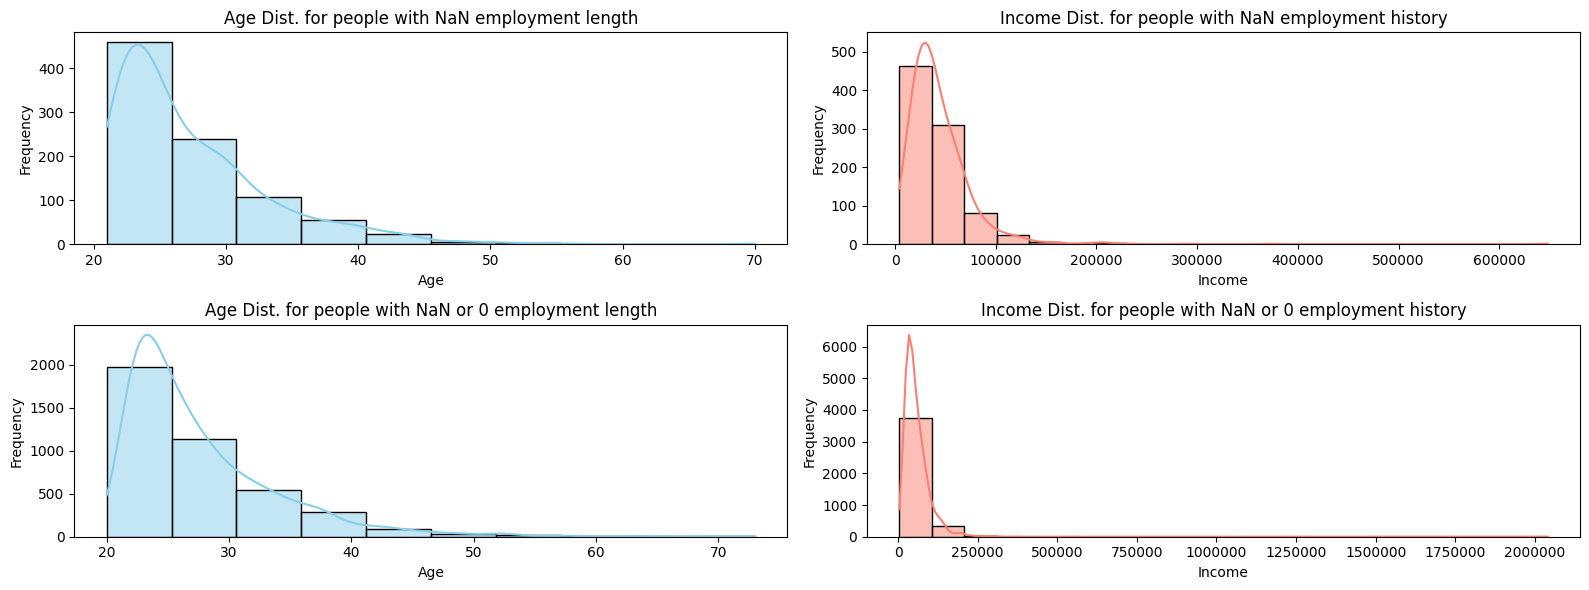

In [8]:
# View an age/income distribution of people with NaN or 0 employment length history

# view of NaN employment
filtered_nan_emp_df = df[df['person_emp_length'].isnull()]
# view of NaN and 0 employment
filtered_no_emp_df = df[(df['person_emp_length'] == 0 | df['person_emp_length'].isnull())]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(16, 6))

# Disable scientific notation for both axes
plt.ticklabel_format(style='plain', axis='x')

# view of NaN employment
sns.histplot(filtered_nan_emp_df['person_age'], kde=True, bins=10, color='skyblue', ax=axes[0,0])
axes[0,0].set_title('Age Dist. for people with NaN employment length')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')

sns.histplot(filtered_nan_emp_df['person_income'], kde=True, bins=20, color='salmon', ax=axes[0,1]) 
axes[0,1].set_title('Income Dist. for people with NaN employment history')
axes[0,1].set_xlabel('Income')
axes[0,1].set_ylabel('Frequency')

# view of NaN and 0 employment
sns.histplot(filtered_no_emp_df['person_age'], kde=True, bins=10, color='skyblue', ax=axes[1,0])
axes[1,0].set_title('Age Dist. for people with NaN or 0 employment length')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Frequency')

sns.histplot(filtered_no_emp_df['person_income'], kde=True, bins=20, color='salmon', ax=axes[1,1]) 
axes[1,1].set_title('Income Dist. for people with NaN or 0 employment history')
axes[1,1].set_xlabel('Income')
axes[1,1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


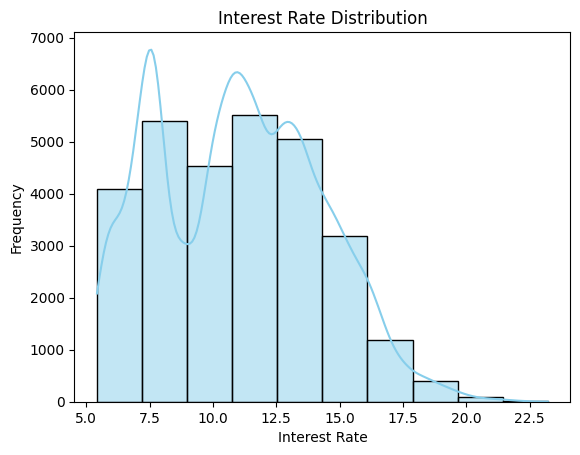

In [9]:
sns.histplot(df['loan_int_rate'], kde=True, bins=10, color='skyblue')

plt.title('Interest Rate Distribution')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')

plt.show()

In [10]:
# approved loans at 0% interest/ no interest amount specified.
zero_int_loans = df.loc[(df['loan_status'] == 1) & (df['loan_int_rate'].isnull())]

zero_int_apps = df.loc[(df['loan_int_rate'].isnull())]

print(f"Number of loan apps without an int. rate: {zero_int_apps.shape[0]}.\n\
Number of approved int. rate loans: {zero_int_loans.shape[0]}.")

# 3116 loan apps and 644 approved loans without an interest rate recorded.
# This seems unlikely and should probably be marked accordingly.

Number of loan apps without an int. rate: 3116.
Number of approved int. rate loans: 644.


In [11]:
# Implemented Solution:

# Charts indicate that applicants with undeclared or 0 employment history are primarily young and/or have low income - as indicated by left skew.
# However there is still a large minority of older/higher income people.

# Our approach to address missing values in person_emp_length and loan_int_rate is to assume these as missing data and therefore mark these as such.
# Marked as missing by letting these values equal -1 instead of NaN.
df['person_emp_length'] = df['person_emp_length'].fillna(-1)
df['loan_int_rate'] = df['loan_int_rate'].fillna(-1)

# We're also adding 'missing indicator' fields to explicity call out rows with missing data:
df['missing_emp_length'] = (df['person_emp_length'] == -1).astype(int)
df['missing_loan_rate'] = (df['loan_int_rate'] == -1).astype(int)
# An idea for future feature engineering/experimention: Assume young people (<26) with low income are students and set their NaN employment lengths to 0.
# Future experiementation could also look into ways to impute loan_int_rate for NaN values.

## Remove Duplicates 

In [12]:
# Identify duplicate rows
duplicates = df.duplicated(keep='first')
num_duplicates = duplicates.sum()

# Remove duplicate rows
df = df.drop_duplicates(keep='first')

print('no. duplicates: ', num_duplicates)

no. duplicates:  165


## Change data types as appropriate - not including categorical data, yet

In [13]:
df['person_age'] = df['person_age'].astype('uint8')
df['person_income'] = df['person_income'].astype('uint32')
df['loan_amnt'] = df['loan_amnt'].astype('uint32')
df['loan_int_rate'] = df['loan_int_rate'].astype('float32')
df['loan_status'] = df['loan_status'].astype('uint8')
df['loan_percent_income'] = df['loan_percent_income'].astype('float32')
df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('uint8')
df['missing_emp_length'] = df['missing_emp_length'].astype('uint8')
df['missing_loan_rate'] = df['missing_loan_rate'].astype('uint8')

In [14]:
# Results show a saving in memory of > 0.9 MB. 
# This step is more relevant to large datasets and pipelines.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  uint8  
 1   person_income               32416 non-null  uint32 
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           32416 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  uint32 
 7   loan_int_rate               32416 non-null  float32
 8   loan_status                 32416 non-null  uint8  
 9   loan_percent_income         32416 non-null  float32
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  uint8  
 12  missing_emp_length          32416 non-null  uint8  
 13  missing_loan_rate           32416 no

## Handling Outliers 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

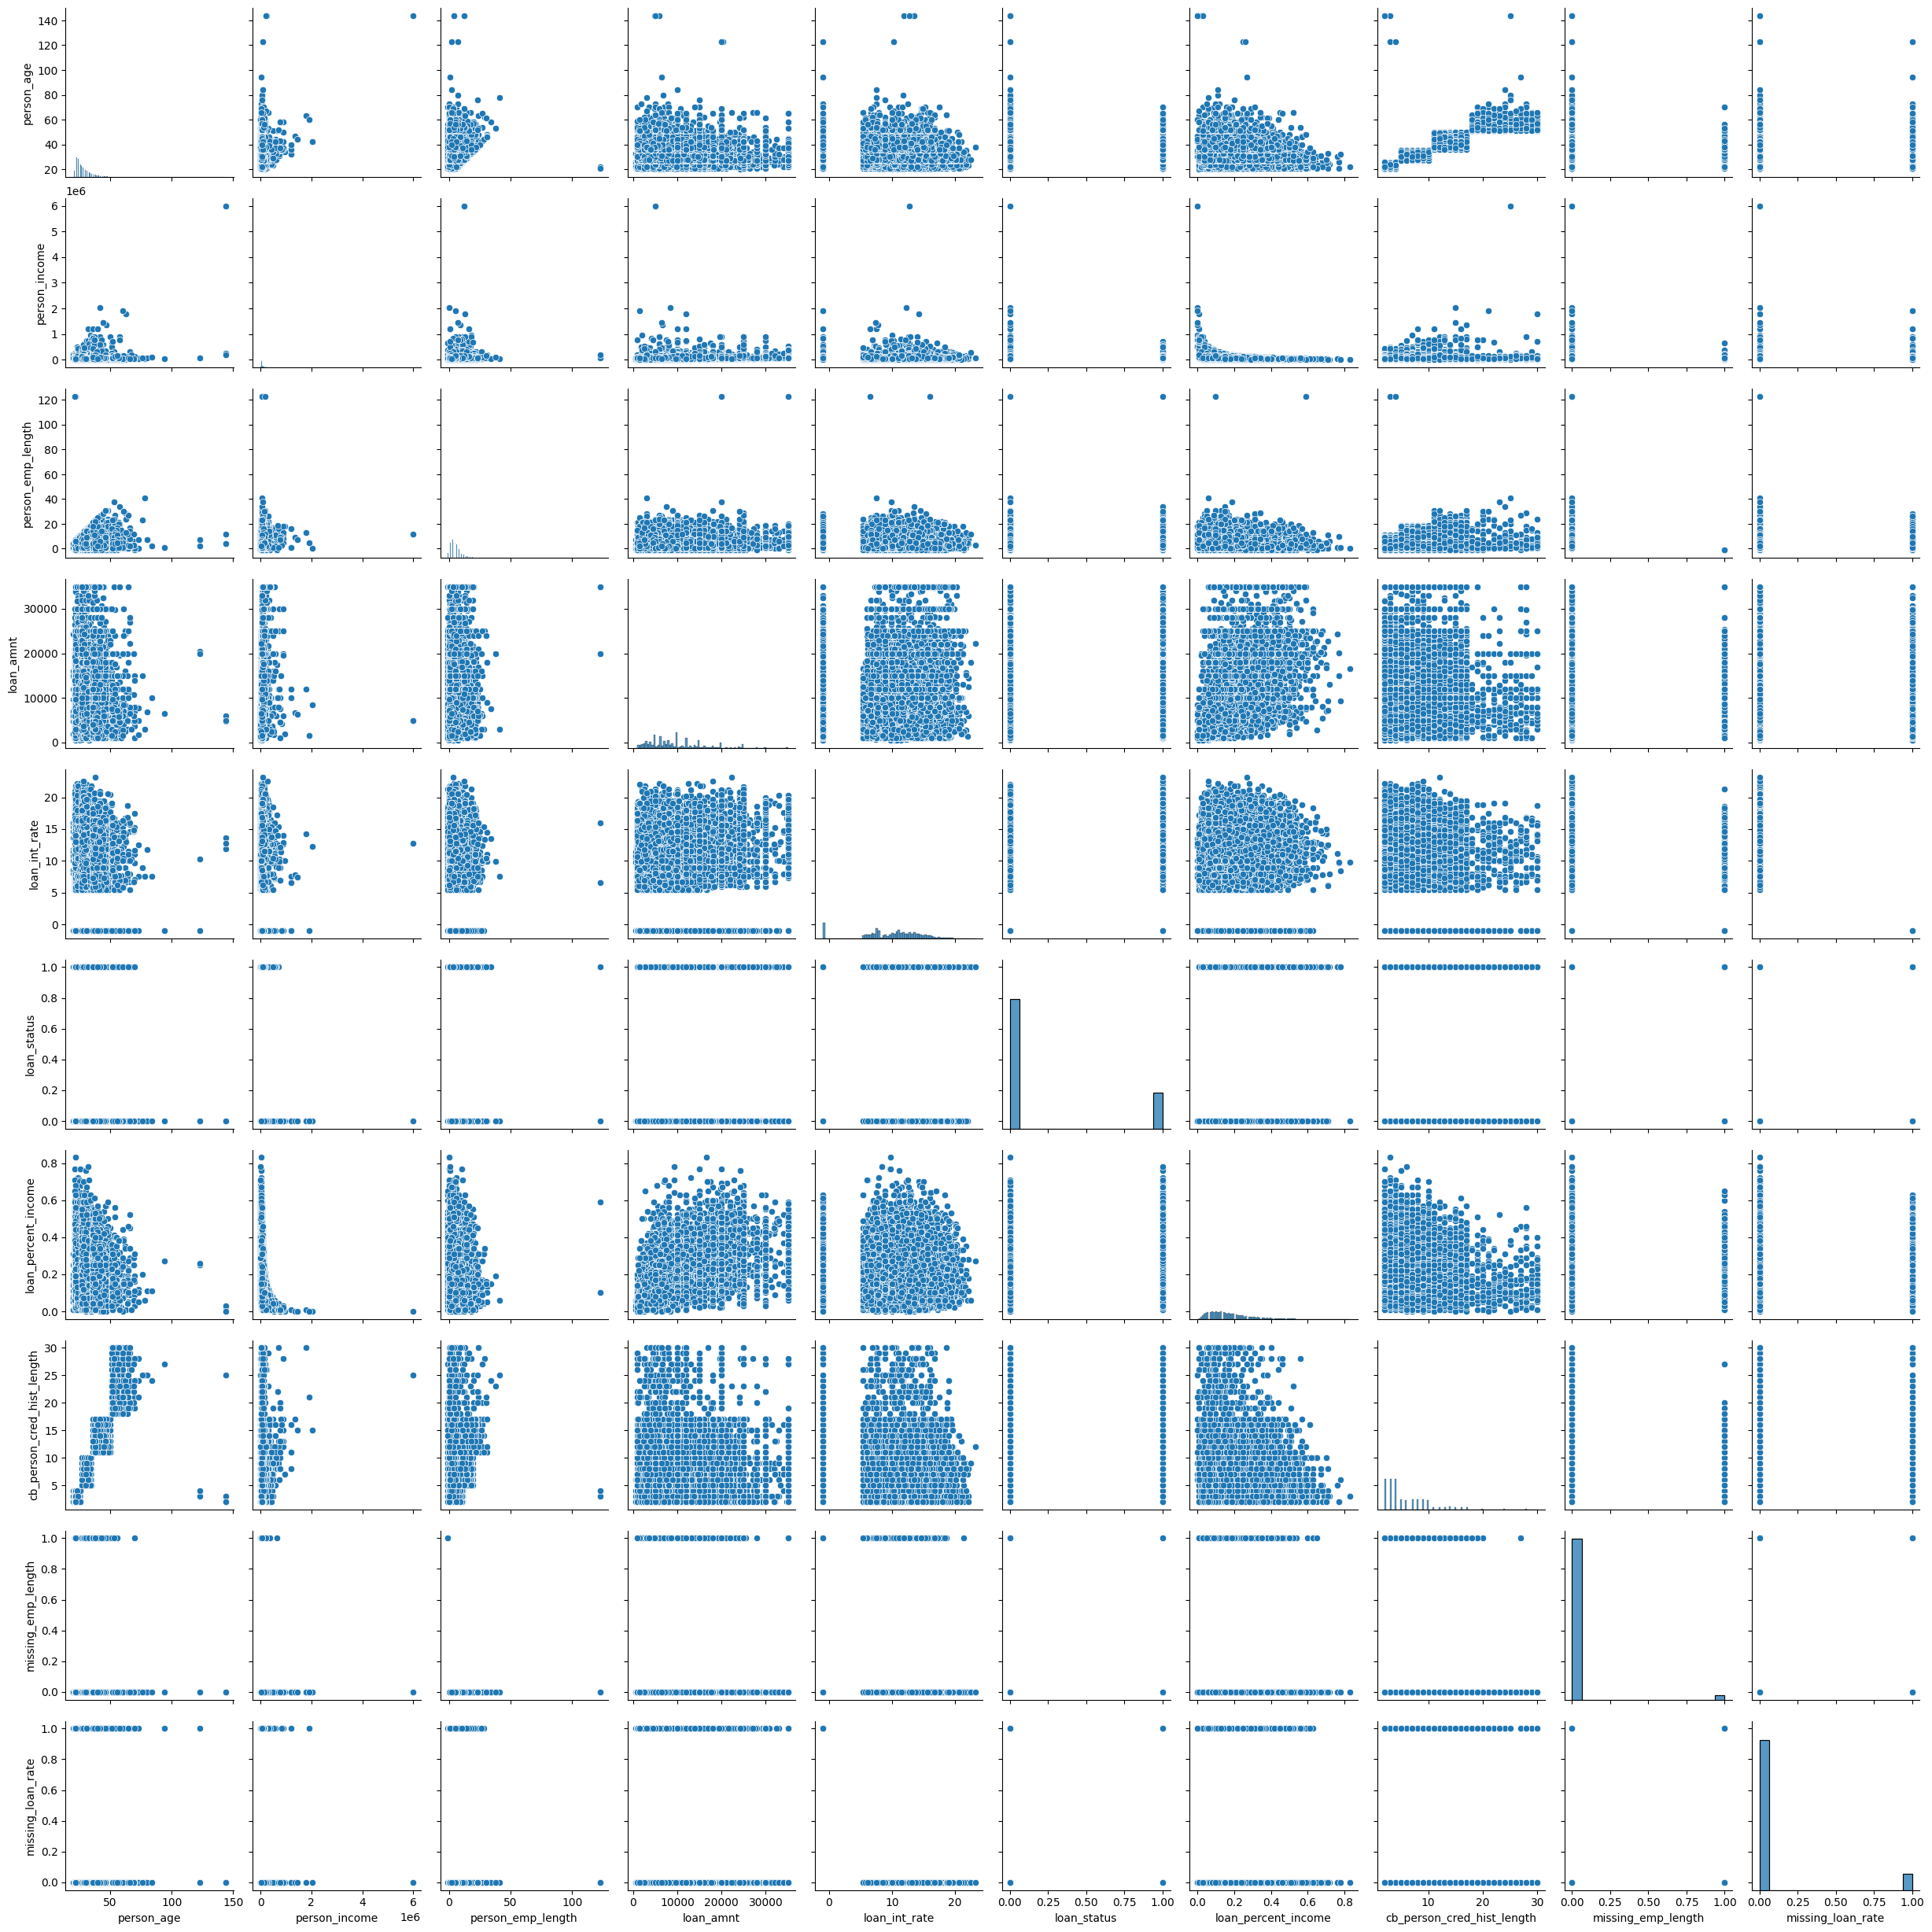

In [15]:
sns.pairplot(df)
plt.show()

In [16]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,missing_emp_length,missing_loan_rate
count,32416.000000,3.241600e+04,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.632064,9593.845632,9.869885,0.218688,0.170250,5.811297,0.027363,0.095478
std,6.354100,6.201558e+04,4.196098,6322.730241,4.688006,0.413363,0.106812,4.059030,0.163141,0.293878
min,20.000000,4.000000e+03,-1.000000,500.000000,-1.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,23.000000,3.854200e+04,2.000000,5000.000000,7.490000,0.000000,0.090000,3.000000,0.000000,0.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.620000,0.000000,0.150000,4.000000,0.000000,0.000000
75%,30.000000,7.921800e+04,7.000000,12250.000000,13.110000,0.000000,0.230000,8.000000,0.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.219999,1.000000,0.830000,30.000000,1.000000,1.000000


In [17]:
# filtered_df = df[df['person_emp_length'] == 0]

# # create bins
# age_bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75] #bin edges
# age_labels = ['20-25', '25-30', '30-35', '35-40', '40-45','45-50','50-55','55-60','60-65','65-70','70-75']
# filtered_df['age_group'] = pd.cut(filtered_df['person_age'], bins=age_bins, labels=age_labels, right=False)

# # grouping
# avg_salary_by_age_group = filtered_df.groupby('age_group')['person_income'].median().reset_index()

# # plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x='age_group', y='person_income', data=avg_salary_by_age_group, palette='viridis')

# plt.title('Avg. Salary dist. by age for never employed')
# plt.xlabel('Age Group')
# plt.ylabel('Avg Salary')
# plt.xticks(rotation=45)
# plt.show()

# print(avg_salary_by_age_group)

In [18]:
# # 65-70 year old bin is an outlier?
# df.loc[(df['person_income'] == 120000.00) & (df['person_emp_length'] == 0.0) & (df['person_age'] >= 65)]

### 1. Age Outliers

In [19]:
# The max age in the dataset is 144. 
# We'll take a look at people aged over 100
df.loc[df['person_age'] >= 100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,missing_loan_rate
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3,0,0
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2,0,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3,0,0
747,123,78000,RENT,7.0,VENTURE,B,20000,-1.00,0,0.26,N,4,0,1
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25,0,0


In [20]:
# Labelling the 3x 144 year olds as 'possibly fraud'. 
# Have also labelled the 123 year olds business venture loan as possibly fraudulent.
df['possible_fraud'] = 0
df.loc[[81, 183, 747, 32297], 'possible_fraud'] = 1

### 2. Employment length outliers

In [21]:
# Find customers where employment length >= age - 15
df.loc[(df['person_emp_length'] > df['person_age'] - 15)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,missing_loan_rate,possible_fraud
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0,0,0
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0,0.10,N,4,0,0,0


In [22]:
# Marking the people in their 20s with 123 YoE as possibly fraudulent.
df.loc[[0, 210], 'possible_fraud'] = 1

### 3. Analysing the nature of the loans

In [23]:
# 9 applicants looking for loans that are approx. 0% of their total income.
# All were unsuccesful. 
df.loc[df['loan_percent_income'] == 0]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,missing_loan_rate,possible_fraud
17834,34,948000,MORTGAGE,18.0,PERSONAL,B,2000,9.99,0,0.0,N,7,0,0,0
18917,35,510000,RENT,1.0,PERSONAL,C,1800,13.48,0,0.0,N,6,0,0,0
27877,30,522000,MORTGAGE,11.0,HOMEIMPROVEMENT,A,2500,7.43,0,0.0,N,9,0,0,0
30049,42,2039784,RENT,0.0,VENTURE,C,8450,12.29,0,0.0,Y,15,0,0,0
31916,43,780000,MORTGAGE,2.0,HOMEIMPROVEMENT,A,1000,8.94,0,0.0,N,11,0,0,0
31922,47,1362000,MORTGAGE,9.0,VENTURE,A,6600,7.74,0,0.0,N,17,0,0,0
31924,44,1440000,MORTGAGE,7.0,DEBTCONSOLIDATION,A,6400,7.40,0,0.0,N,15,0,0,0
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.0,N,25,0,0,1
32546,60,1900000,MORTGAGE,5.0,PERSONAL,A,1500,-1.00,0,0.0,N,21,0,1,0


In [24]:
# Marking as possibly fraudulent.
df.loc[df['loan_percent_income'] == 0, 'possible_fraud'] = 1

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


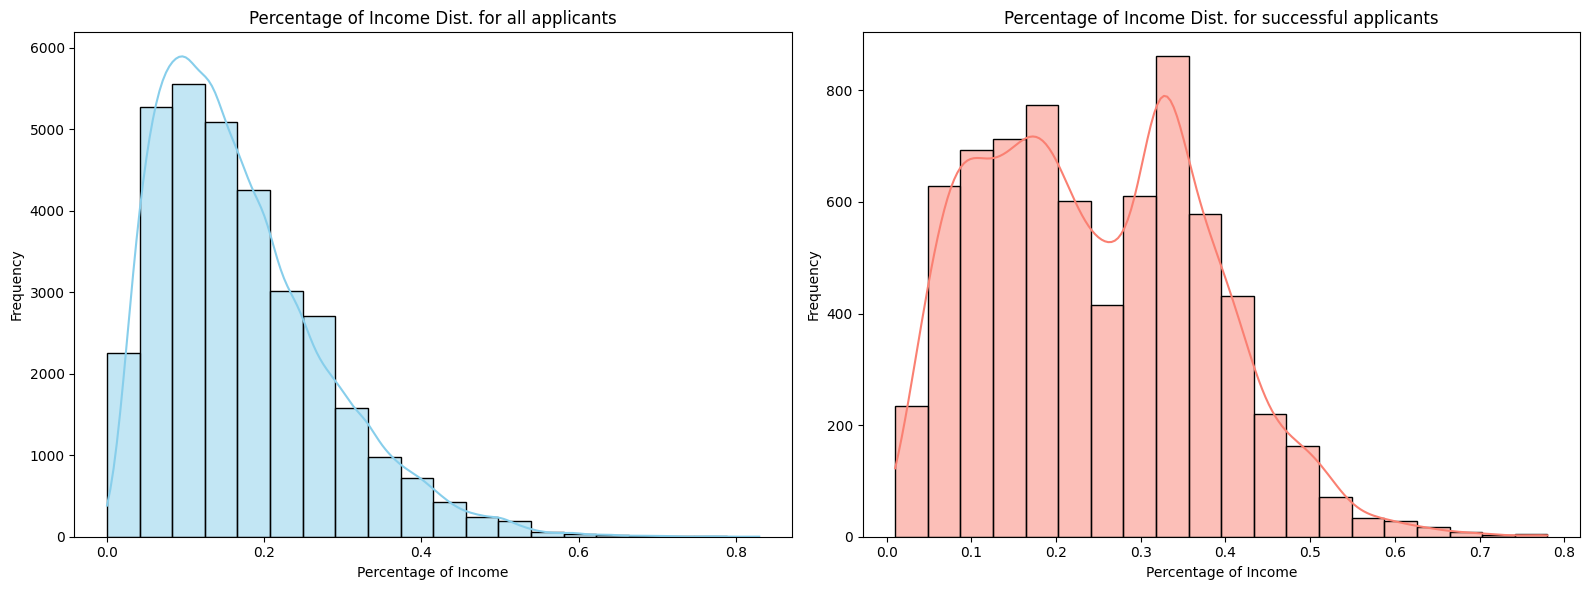

In [25]:
# Analysing the distribution of all loan applicant profiles vs succesful loan profiles

# succesful applicants
succesful_loans_df = df[df['loan_status'] == 1]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Disable scientific notation for both axes
plt.ticklabel_format(style='plain', axis='x')

# view of NaN employment
sns.histplot(df['loan_percent_income'], kde=True, bins=20, color='skyblue', ax=axes[0])
axes[0].set_title('Percentage of Income Dist. for all applicants')
axes[0].set_xlabel('Percentage of Income')
axes[0].set_ylabel('Frequency')

sns.histplot(succesful_loans_df['loan_percent_income'], kde=True, bins=20, color='salmon', ax=axes[1]) 
axes[1].set_title('Percentage of Income Dist. for successful applicants')
axes[1].set_xlabel('Percentage of Income')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [26]:
# Distribution of all loan applications
mean = df['loan_percent_income'].mean()
median = df['loan_percent_income'].median()
std_dev = df['loan_percent_income'].std()
print(f'All Loan Applications:\nmean: {mean}, median: {median},\nstd dev: {std_dev}')

All Loan Applications:
mean: 0.1702498495578766, median: 0.15000000596046448,
std dev: 0.10681197047233582


In [27]:
# Distribution of successful loan applications
mean = succesful_loans_df['loan_percent_income'].mean()
median = succesful_loans_df['loan_percent_income'].median()
std_dev = succesful_loans_df['loan_percent_income'].std()
print(f'Successful Loan Applications:\nmean: {mean}, median: {median},\nstd dev: {std_dev}')

Successful Loan Applications:
mean: 0.24690644443035126, median: 0.23999999463558197,
std dev: 0.13210350275039673


In [28]:
# As shown, majority of loan applicants were centred around relatively 
# small loans relative to income.

# However approved loans were almost normally distributed,
# with slightly larger loans more likely to be approved.

In [29]:
# Looking at the top 5% of loan applications in terms of loan v income
two_std_dev = mean + 2*std_dev
df.loc[df['loan_percent_income'] >= two_std_dev]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,missing_loan_rate,possible_fraud
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,0,0,1
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,0,0,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,0,0,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,0,0,0
22,22,65000,RENT,4.0,EDUCATION,D,34000,17.58,1,0.52,N,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31881,40,14400,OWN,10.0,HOMEIMPROVEMENT,A,8000,7.14,1,0.56,N,12,0,0,0
31901,40,33600,RENT,8.0,EDUCATION,E,19275,14.50,1,0.57,N,11,0,0,0
31917,38,37440,RENT,14.0,VENTURE,C,19750,13.92,1,0.53,N,16,0,0,0
32307,54,53700,RENT,1.0,HOMEIMPROVEMENT,D,29850,-1.00,1,0.56,Y,28,0,1,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


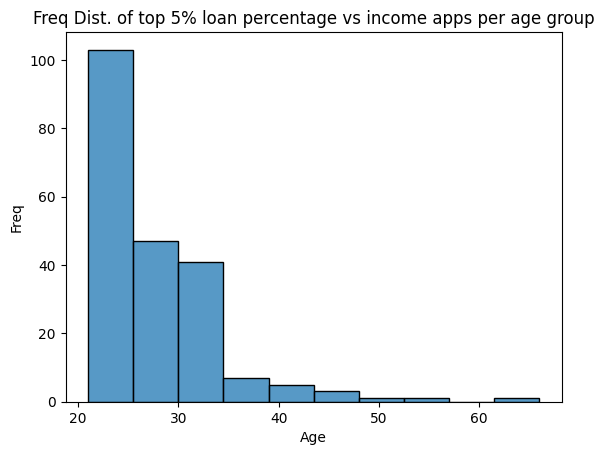

In [30]:
filtered = df.loc[df['loan_percent_income'] >= two_std_dev]
sns.histplot(filtered['person_age'], bins = 10, kde=False)
plt.xlabel('Age')
plt.ylabel('Freq')
plt.title('Freq Dist. of top 5% loan percentage vs income apps per age group')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


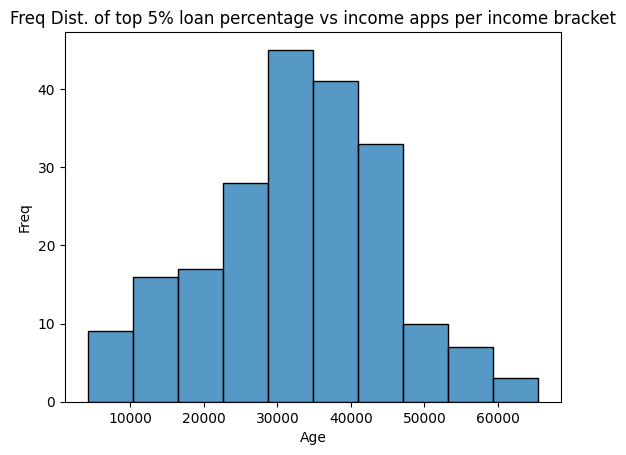

In [31]:
filtered = df.loc[df['loan_percent_income'] >= two_std_dev]
sns.histplot(filtered['person_income'], bins = 10, kde=False)
plt.xlabel('Age')
plt.ylabel('Freq')
plt.title('Freq Dist. of top 5% loan percentage vs income apps per income bracket')
plt.show()

In [32]:
# Didn't do any further feature engineering,
# but this can be further explored in future iterations.

# Scaling & One-Hot Encoding

In [33]:
# We are using min-max scaling for continuous variables as the underlying data is not normally distributed
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df[['person_age', 'person_income','loan_amnt']] = min_max_scaler.fit_transform(df[['person_age','person_income','loan_amnt']])
df.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,missing_loan_rate,possible_fraud
16774,0.032258,0.006004,OWN,7.0,VENTURE,C,0.043478,12.53,0,0.05,N,4,0,0,0
27558,0.104839,0.018896,MORTGAGE,3.0,MEDICAL,D,0.449275,15.99,1,0.12,N,5,0,0,0
7411,0.048387,0.008172,MORTGAGE,10.0,MEDICAL,C,0.318841,14.65,0,0.22,N,4,0,0,0
8410,0.024194,0.011841,RENT,4.0,EDUCATION,B,0.202899,11.83,0,0.10,N,2,0,0,0
17048,0.016129,0.007672,MORTGAGE,2.0,MEDICAL,B,0.623188,9.91,0,0.44,N,4,0,0,0


In [34]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse=False)

encoded_data = encoder.fit_transform(df[['person_home_ownership','loan_intent','loan_grade']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['person_home_ownership','loan_intent','loan_grade']))
df_final = pd.concat([df.drop(['person_home_ownership','loan_intent','loan_grade'], axis=1), encoded_df], axis=1)

df_final.sample(5)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
16869,0.016129,0.005097,2.0,0.020290,19.290001,1.0,0.03,N,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19543,0.064516,0.007872,12.0,0.333333,-1.000000,1.0,0.23,N,7.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4815,0.040323,0.005170,0.0,0.130435,11.710000,0.0,0.14,N,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10688,0.048387,0.011007,-1.0,0.130435,-1.000000,0.0,0.07,N,4.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12785,0.016129,0.013509,0.0,0.333333,11.990000,0.0,0.14,N,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Converting Ys and Ns to 1s and 0s
df_final['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})
df_final.head()

/tmp/ipykernel_29/2664060158.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,0.016129,0.009173,123.0,1.000000,16.02,1.0,0.59,1.0,3.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.008065,0.000934,5.0,0.014493,11.14,0.0,0.10,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.040323,0.000934,1.0,0.144928,12.87,1.0,0.57,0.0,3.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.024194,0.010257,4.0,1.000000,15.23,1.0,0.53,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.032258,0.008406,8.0,1.000000,14.27,1.0,0.55,1.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
# Mark NaN values in person_emp_length and loan_int_rate

df_final['missing_emp_length'] = df_final['person_emp_length'].isnull().astype(int)
df_final['missing_int_rate'] = df_final['loan_int_rate'].isnull().astype(int)

# Also mark loans with 0 interest as a missing value
df_final.loc[df_final['loan_int_rate'] == 0, 'missing_int_rate'] = 1

# Let NaNs equal -1 to indicate missing value
df_final.loc[df_final['person_emp_length'].isnull(), 'person_emp_length'] = -1
df_final.loc[df_final['loan_int_rate'].isnull(), 'loan_int_rate'] = -1

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32581 entries, 0 to 32279
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32416 non-null  float64
 1   person_income                32416 non-null  float64
 2   person_emp_length            32581 non-null  float64
 3   loan_amnt                    32416 non-null  float64
 4   loan_int_rate                32581 non-null  float32
 5   loan_status                  32416 non-null  float64
 6   loan_percent_income          32416 non-null  float32
 7   cb_person_default_on_file    32416 non-null  float64
 8   cb_person_cred_hist_length   32416 non-null  float64
 9   missing_emp_length           32581 non-null  int64  
 10  missing_loan_rate            32416 non-null  float64
 11  possible_fraud               32416 non-null  float64
 12  person_home_ownership_OTHER  32416 non-null  float64
 13  person_home_ownership

In [37]:
print(df_final.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'missing_emp_length', 'missing_loan_rate', 'possible_fraud',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B',
       'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F',
       'loan_grade_G', 'missing_int_rate'],
      dtype='object')


In [38]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32581 entries, 0 to 32279
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32416 non-null  float64
 1   person_income                32416 non-null  float64
 2   person_emp_length            32581 non-null  float64
 3   loan_amnt                    32416 non-null  float64
 4   loan_int_rate                32581 non-null  float32
 5   loan_status                  32416 non-null  float64
 6   loan_percent_income          32416 non-null  float32
 7   cb_person_default_on_file    32416 non-null  float64
 8   cb_person_cred_hist_length   32416 non-null  float64
 9   missing_emp_length           32581 non-null  int64  
 10  missing_loan_rate            32416 non-null  float64
 11  possible_fraud               32416 non-null  float64
 12  person_home_ownership_OTHER  32416 non-null  float64
 13  person_home_ownership

In [39]:
df_final[df_final.isnull().any(axis=1)]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,missing_emp_length,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,missing_int_rate
32416,0.596774,0.003336,1.0,0.173913,-1.00,0.0,0.27,0.0,27.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
32417,0.258065,0.008005,2.0,0.275362,-1.00,0.0,0.19,0.0,29.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
32418,0.298387,0.011007,0.0,0.176812,10.99,0.0,0.09,0.0,21.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
32419,0.330645,0.008172,3.0,0.188406,7.49,0.0,0.13,0.0,23.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
32420,0.298387,0.012239,4.0,0.177536,7.66,0.0,0.09,0.0,29.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32010,NaN,NaN,-1.0,NaN,-1.00,NaN,NaN,NaN,NaN,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
32047,NaN,NaN,-1.0,NaN,-1.00,NaN,NaN,NaN,NaN,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
32172,NaN,NaN,-1.0,NaN,-1.00,NaN,NaN,NaN,NaN,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
32259,NaN,NaN,-1.0,NaN,-1.00,NaN,NaN,NaN,NaN,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


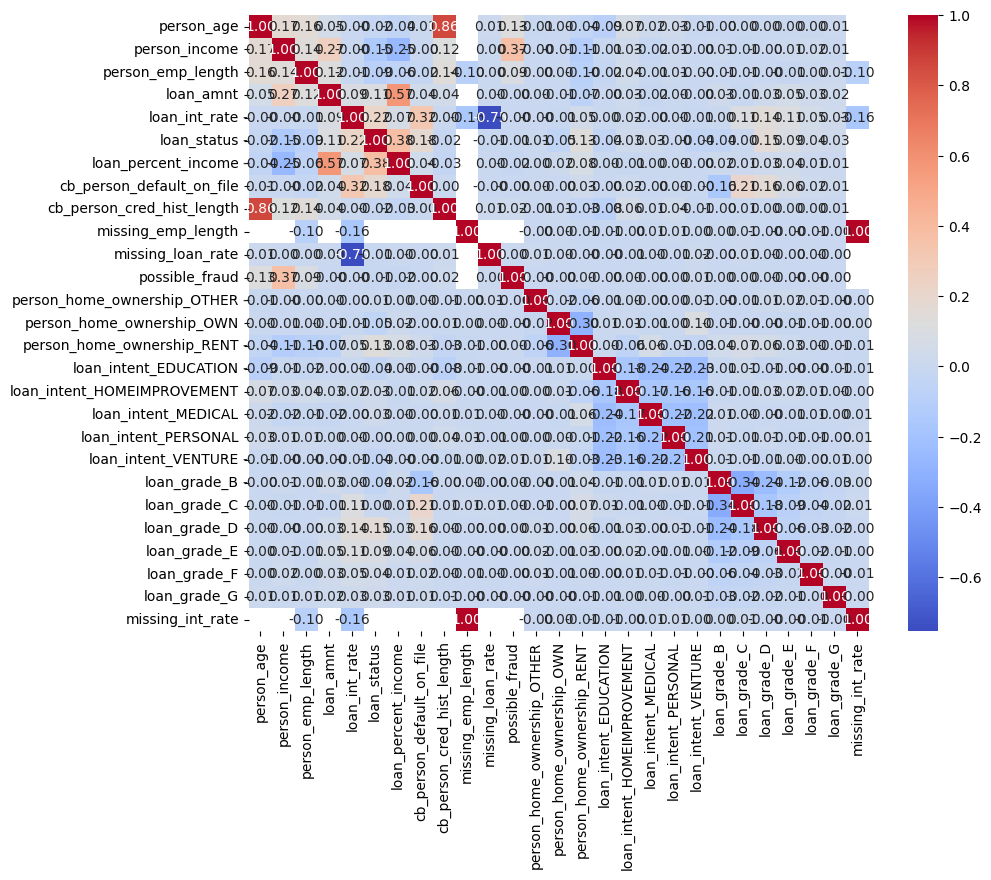

In [40]:
# Assuming your DataFrame is df
correlation_matrix = df_final.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming df has a continuous variable (e.g., 'loan_amount') and a categorical target (e.g., 'loan_status')
model = ols('loan_status ~ person_income + loan_int_rate + loan_percent_income', data=df_final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_RENT', 'person_income'

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Prepare the data (features and labels)
X = df_final.drop('loan_status', axis=1)  # Features
y = df_final['loan_status']  # Target label

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Define the column transformer for preprocessing
# - StandardScaler for numerical columns: 'age', 'income', 'credit_score'
# # - OneHotEncoder for categorical columns: 'gender'
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), ['age', 'income', 'credit_score']),
#         ('cat', OneHotEncoder(drop='first'), ['gender'])
#     ])

# Step 3: Create and train the Logistic Regression model
classifier = LogisticRegression(solver='liblinear')  # 'liblinear' is a good choice for smaller datasets
classifier.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = classifier.predict(X_test)

# Step 5: Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

In [ ]:
# XGBoost script
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

In [ ]:
# With Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimaors': 300,
    'subsample': 0.9
}

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Grid Search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=1)

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Results:

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}

Accuracy: 0.933404940923737
9## 
Confusion Matri
x:[5027 45]
 4[389 1056]0
 56]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.96      0.73      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.94      0.93      0.93      6517

In [ ]:
df_final.to_csv('cleaned_dataset_v1.csv', index=True, header=True)

# Evaluation Analysis

In [ ]:
# Create a DataFrame with the test set and add columns for actual and predicted values
test_results_df = X_test.copy()  # Copy X_test to avoid modifying the original data
test_results_df['actual'] = y_test
test_results_df['predicted'] = y_pred

# Filter the DataFrame for rows with incorrect predictions
incorrect_predictions_df = test_results_df[test_results_df['actual'] != test_results_df['predicted']]

# View the DataFrame with incorrect predictions
incorrect_predictions_df

In [ ]:
incorrect_predictions_df.head()

In [ ]:
incorrect_predictions_df.describe()

In [ ]:
df_final.describe()

In [ ]:
rows_to_revert = df.index.isin(incorrect_predictions_df.index)

# Apply inverse transform to only those rows
df.loc[rows_to_revert, ['person_age', 'person_income', 'loan_amnt']] = min_max_scaler.inverse_transform(
    df.loc[rows_to_revert, ['person_age', 'person_income', 'loan_amnt']]
)

# Display the modified rows
df.loc[rows_to_revert]

In [ ]:
df.loc[rows_to_revert].describe()

In [ ]:
results_df = df.loc[rows_to_revert]

In [ ]:
sns.histplot(results_df['person_age'], bins = 10, kde=False)
plt.xlabel('Age')
plt.ylabel('Freq')
plt.title('Freq Dist. of age of incorrectly predicted entries')
plt.show()

In [ ]:
sns.histplot(results_df['person_emp_length'], bins = 10, kde=False)
plt.xlabel('Employment Length')
plt.ylabel('Freq')
plt.title('Freq Dist. of employment length of incorrectly predicted entries')
plt.show()

In [ ]:
sns.histplot(results_df['loan_amnt'], bins = 10, kde=False)
plt.xlabel('Loan Amnt')
plt.ylabel('Freq')
plt.title('Freq Dist. of loan amnt. of incorrectly predicted entries')
plt.show()

In [ ]:
print('approved loans:', results_df[results_df['loan_status'] == 1].shape[0])
print('total inaccurate predictions:', results_df.shape[0])